# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

We begin by importing the necessary libraries.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, we load the data provided and perform some initial diagnostics.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('The demographics dataset has ' + str(azdias.shape[0]) + ' rows and ' + str(azdias.shape[1]) + ' columns')
azdias.head(10)

The demographics dataset has 891221 rows and 85 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
print('The feature dataset has {0} rows and {1} columns, which matches the number of attributes of the demographics dataset'.format(feat_info.shape[0], feat_info.shape[1]))
feat_info.head()

The feature dataset has 85 rows and 4 columns, which matches the number of attributes of the demographics dataset


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We use this file to help  make cleaning decisions during this stage of the project. First of all, we assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We parse this data to analyze how much of the data is missing. 

In [5]:
# We loop through the columns of the demographic dataset, find the corresponding missing values from the features info
# We parse these missing values, and then look at the rows of the column and replace the missing values by NaN

# We start by writing a helper function which we will use to map our codes to null values
def compare_codes(x):
    # we first check for NaN values, handling the exception accordingly
    try:
        if np.isnan(x):
            return(True)
    except:
        pass
    
    # we need to be careful about the conversion of floats to strings, so we split on the decimal
    # separator and only keep the first part
    return(str(x).split('.')[0] in missing_parsed)

for c in azdias:
    missing = feat_info[feat_info.attribute == c].missing_or_unknown.values.tolist()
    missing_parsed = missing[0].split('[')[1].split(']')[0].split(',')
    
    
    check = azdias[c].apply(compare_codes)    
    azdias.loc[check, c] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col = azdias.isnull().sum()

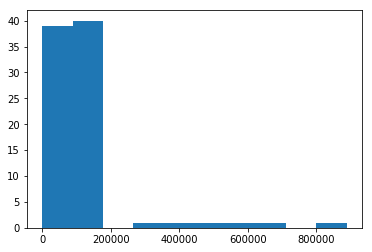

In [7]:
# Investigate patterns in the amount of missing data in each column.
hist_col = plt.hist(missing_col)
plt.show(hist_col)

In [8]:
# We visualize variables which have very little missing values
missing_col.sort_values()

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

In [9]:
# We visualize the 90% percentile
missing_col.quantile(0.90)

142122.40000000014

In [10]:
# Remove the outlier columns from the dataset.
# Based on the result above, we set the max number of NA's to be 150,000
max_number_of_nas = 150000
azdias_reduced = azdias.loc[:, (missing_col <= max_number_of_nas)]

In [11]:
# We visualize the columns which have a number of missing values higher than our thresholds
high_na_col = azdias.loc[:, (missing_col > max_number_of_nas)].columns.tolist()
high_na_col

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'KKK',
 'REGIOTYP']

Looking at the histogram of missing values, we can see that most variables contain missing values (which is to be expected with real-life data). Yet, while most columns have between 0 and 150,000 missing values, or less than 20% since the total number of observations is 891,221, we have a long right tail. We choose a threshold of 150,000 missing values, close to the 90th percentile. Variables with more missing values are excluded from the dataset, to avoid any potential bias.

As a result, the following columns are excluded from the dataset:
- AGER_TYP
- TITEL_KZ
- GEBURTSJAHR
- ALTER_HH
- REGIO_TYP
- KBA05_BAUMAX
- KKK
- KK_KUNDENTYP

Looking at some patterns in the missing values, we can see variables seem to capture similar information, as designated by a suffix. For instance, all the SEMIO_* have 0 missing values, while PLZ8_* variables all have 116,515 missing values. This is confirmed by looking at the data dictionary: the prefix describes the general information, while the suffix describes the level of the variable. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we perform a similar assessment for the rows of the dataset.

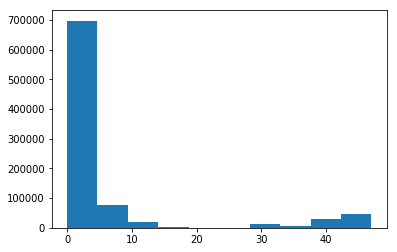

In [12]:
# How much data is missing in each row of the dataset?
missing_row = azdias_reduced.isnull().sum(axis = 1)
hist_row = plt.hist(missing_row)
plt.show(hist_row)

In [13]:
# We visualize the 90th percentile to have a good idea of where to set the threshold
missing_row.quantile(0.9)

32.0

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Based on the result above, we set the threshold to 36
max_na_row = missing_row.quantile(0.9)
low_na = azdias_reduced.loc[(missing_row <= max_na_row), :]
high_na = azdias_reduced.loc[(missing_row > max_na_row), :]

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# We start by identifying which columns have the fewest missing values
low_na_col = missing_col.sort_values().head()

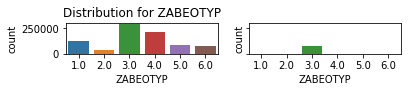

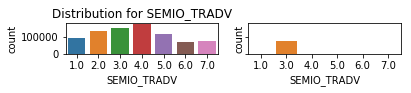

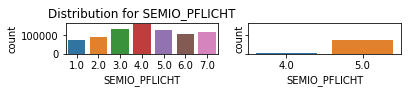

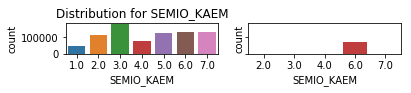

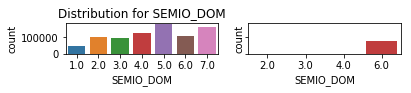

In [16]:
# Then we compare the distribution of values for these columns between the two subsets
# We write a function to do this comparison on a given column

def compare_distrib(col, i):
    ax = plt.subplot(6,2,i, title = "Distribution for " + col)
    sns.countplot(col, data = low_na)
    ax2 = plt.subplot(6,2,i + 1, sharey = ax)
    plt.setp(ax2.get_yticklabels(), visible=False)
    sns.countplot(col, data = high_na)
    plt.tight_layout
    plt.show()
    
# We apply our function to our columns with low missing values
i = 1
for c in low_na_col.index.values:
    compare_distrib(c, i)
    i = i + 2

In [17]:
# For now, we only keep the rows with low missing values for further analysis
# We keep the number of rows which were thus excluded handy for future analysis
azdias_low_missing = low_na.copy()
excluded_rows_azdias = sum(missing_row>max_na_row)

Looking at the distribution of missing values in each row, we see most rows have few missing values (<20) but there is a group of them which has between 40 or 50 missing values, which represents approximately 50% of the features. We thus set a threshold at 32, based on the quantile and split these rows into two subsets. We could also set it at 20, which graphically appears to be a good split between two groups of data.

Focusing on columns which have no or very low missing values, we can see that the distribution of values between the two subsets is qualitatively different. The plots above are not perfect (not same scale, not very readable) but they still provide a good idea of what is going on: different distribution of values between the rows with high vs. low missing values. As a result, these data appear to be special, and we probably want to give them special attention. Nonetheless, for now we only keep the rows with low missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [18]:
# How many features are there of each data type?
feat_info.groupby("type")['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis

In [19]:
# We first find the binary variables
# We can leave them as they are
binary = [col for col in azdias_low_missing if 
               azdias_low_missing[col].dropna().value_counts().index.isin([0,1]).all()]
binary

['GREEN_AVANTGARDE', 'SOHO_KZ']

In [20]:
# Looking at the data dictionary, we also determine OST_WEST_KZ is a binary variable taking non-numeric values
# We re-encode it with W as the basis (0) and 1 for O
azdias_low_missing.OST_WEST_KZ = azdias_low_missing.OST_WEST_KZ.map({'W':0, 'O': 1})

In [21]:
# We look at all the categorical variables
categorical_col = feat_info.loc[feat_info.type == 'categorical'].attribute
categorical_col

# From there we can determine a list of columns to re-encode through one-hot encoding
to_keep = []
for c in categorical_col:
    if not (c in high_na_col or c in binary):
        to_keep.append(True)
    else:
        to_keep.append(False)

categorical_col_tocode = categorical_col[to_keep]
categorical_col_tocode

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_encoded = pd.get_dummies(azdias_low_missing, columns = categorical_col_tocode)

First of all, regarding the binary variables, the OST_WEST_KZ variable is binary but contains non-numeric values, so I had to transform it to numeric values, choosing W to be the basis (i.e. be encoded by 0). I then had to identify categorical variables to re-encode, and was left with 13 multi-level variables, for which I created dummies to be used for further analysis. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# We start by visualizing a few rows for this variable
azdias_encoded.PRAEGENDE_JUGENDJAHRE.head(10)

1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [24]:
# These values are not very informative 
# Looking at the data dictionary, we can separate two pieces of information
# The first piece of information refers to the generation, which we can encode with an interval categorical variable
# We use the level 0 for the 40's, 1 for the 50's and so on until 5 for the 90's
azdias_encoded['DECADE'] = azdias_encoded.PRAEGENDE_JUGENDJAHRE.map({1:0 ,2:0, 3:1, 4:1, 5:2, 6:2,
                                                                     7:2, 8:3, 9:3, 10:4, 11:4, 12:4,
                                                                     13:4, 14:5, 15:5})

In [25]:
# We check our mapping is correct
azdias_encoded[['PRAEGENDE_JUGENDJAHRE', 'DECADE']].head()

,PRAEGENDE_JUGENDJAHRE,DECADE
1,14.0,5.0
2,15.0,5.0
3,8.0,3.0
4,8.0,3.0
5,3.0,1.0


In [26]:
# The second piece of information captured in this variable is the movement, which we capture in a binary variable
# We set 0 to be mainstream, and 1 to be avant-garde
azdias_encoded['MOVEMENT'] = azdias_encoded.PRAEGENDE_JUGENDJAHRE.map({1:0 ,2:1, 3:0, 4:1, 5:0, 6:1,
                                                                     7:1, 8:0, 9:1, 10:0, 11:1, 12:0,
                                                                     13:1, 14:0, 15:1})

In [27]:
# We verify our mapping
azdias_encoded[['PRAEGENDE_JUGENDJAHRE', 'MOVEMENT']].head()

,PRAEGENDE_JUGENDJAHRE,MOVEMENT
1,14.0,0.0
2,15.0,1.0
3,8.0,0.0
4,8.0,0.0
5,3.0,0.0


In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Looking at the data dictionary, we just have to split these numbers in two
# The first digit represents the wealth, while the second represents the life stage
# We start by initializing two new variables with missing values
azdias_encoded['WEALTH'] = np.nan
azdias_encoded['LIFE_STAGE'] = np.nan

# Where CAMEO_INTL_2015 has a value, we replace these two variables with the appropriate digits
azdias_encoded['WEALTH'].loc[azdias_encoded.CAMEO_INTL_2015.notnull()] = azdias_encoded.CAMEO_INTL_2015.loc[azdias_encoded.CAMEO_INTL_2015.notnull()].apply(str).apply(lambda x: x[0]).astype(int)
azdias_encoded['LIFE_STAGE'].loc[azdias_encoded.CAMEO_INTL_2015.notnull()] = azdias_encoded.CAMEO_INTL_2015.loc[azdias_encoded.CAMEO_INTL_2015.notnull()].apply(str).apply(lambda x: x[1]).astype(int)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
# We can verify our mapping
azdias_encoded[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head()

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0


All the work for the variables PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 is documented in details in the comments of the relevant cells. Let us examine the remaining mixed-type features to determine whether we need to engineer them:
- LP_LEBENSPHASE_GROB seems to mix information from life stage and wealth. This seems redundant with the CAMEO_INTL_2015 variable, so we will get rid of it
- LP_LEBENSPHASE_FEIN extends on the previous variable, so similarly we will get rid of it
- from WOHNLAGE, we could extract a binary flag of the neighborhood being urban or rural, but the levels are confusing for the quality of the neighborhood so we extract the rural flag but otherwise drop the variable 
- from PLZ8_BAUMAX, we can extract information about the more common type of building (business vs. residential) in the macrocell, but the size of the building is confusing between the two types so we extract the building type and otherwise drop the variable 

#### Step 1.2.3: Complete Feature Selection

We put everything together, making sure we only have the columns we want for analysis in our dataset.

In [30]:
# Finish cleaning up
# We start with WOHNLAGE, extracting both the quality of the neighborhood
azdias_encoded['RURAL'] = azdias_encoded.WOHNLAGE.map({0:0 ,1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1})

In [31]:
# We then extract information from KBA05_BAUMAX and PLZ8_BAUMAX 
azdias_encoded['REGION_BUILDING_TYPE'] = azdias_encoded.PLZ8_BAUMAX.map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1})

In [32]:
# We only have to drop columns for the mixed features 
mixed_col = feat_info.loc[feat_info.type == 'mixed', 'attribute'].values.tolist()
mixed_col.remove('KBA05_BAUMAX') # it was already removed
azdias_encoded.drop(mixed_col, axis = 1, inplace = True)

# Doing a first pass of the analysis, we noticed that GEBAEUDETYP_5.0 would be missing from customers data
# We remove them here to prevent issues
# I am confident in doing this since neither of these columns seemed to play a prevalent role in the main PC's
# These are variables which result from engineering categorical variables
# So this problem is probably due to levels being present for the general population, not the customers

azdias_encoded.drop(['GEBAEUDETYP_5.0'], axis = 1, inplace = True)

In [33]:
# We create a copy of our dataframe for analysis, on which we will perform scaling and PCA
azdias_analysis = azdias_encoded.copy()

### Step 1.3: Create a Cleaning Function

We create a cleaning function to make it modular and reusable. In particular, we want to be able to re-use for the dataset for the mail-order company.

In [54]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    def compare_codes(x):
    # we first check for NaN values, handling the exception accordingly
        try:
            if np.isnan(x):
                return(True)
        except:
            pass

        # we need to be careful about the conversion of floats to strings, so we split on the decimal
        # separator and only keep the first part
        return(str(x).split('.')[0] in missing_parsed)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for c in df:
        missing = feat_info[feat_info.attribute == c].missing_or_unknown.values.tolist()
        missing_parsed = missing[0].split('[')[1].split(']')[0].split(',')

        check = df[c].apply(compare_codes)    
        df.loc[check, c] = np.nan
    
    # remove selected columns and rows, ...
    # for the columns, we need to make sure we are dropping the same columns by names, 
    # even though the distribution of missing values might be different in the customer dataset
    df.drop(high_na_col, axis = 1, inplace = True)
    
    # for the rows, we can apply the same heuristic
    # we keep the number of rows excluded handy for future analysis
    missing_row = df.isnull().sum(axis = 1)
    max_na_row = missing_row.quantile(0.9)
    df_filtered = df.loc[(missing_row <= max_na_row), :]
    rows_excluded = sum(missing_row > max_na_row)
    
    # select, re-encode, and engineer column values.
    df_filtered.OST_WEST_KZ = df_filtered.OST_WEST_KZ.map({'W':0, 'O': 1})
    categorical_col = feat_info.loc[feat_info.type == 'categorical'].attribute
    categorical_col

    # From there we can determine a list of columns to re-encode through one-hot encoding
    to_keep = []
    for c in categorical_col:
        if not (c in high_na_col or c in binary):
            to_keep.append(True)
        else:
            to_keep.append(False)

    categorical_col_tocode = categorical_col[to_keep]
    df_encoded = pd.get_dummies(df_filtered, columns = categorical_col_tocode)
    df_encoded['DECADE'] = df_encoded.PRAEGENDE_JUGENDJAHRE.map({1:0 ,2:0, 3:1, 4:1, 5:2, 6:2,
                                                                     7:2, 8:3, 9:3, 10:4, 11:4, 12:4,
                                                                     13:4, 14:5, 15:5})
    
    df_encoded['MOVEMENT'] = df_encoded.PRAEGENDE_JUGENDJAHRE.map({1:0 ,2:1, 3:0, 4:1, 5:0, 6:1,
                                                                     7:1, 8:0, 9:1, 10:0, 11:1, 12:0,
                                                                     13:1, 14:0, 15:1})
    
    df_encoded['WEALTH'] = np.nan
    df_encoded['LIFE_STAGE'] = np.nan

    # Where CAMEO_INTL_2015 has a value, we replace these two variables with the appropriate digits
    df_encoded['WEALTH'].loc[df_encoded.CAMEO_INTL_2015.notnull()] = df_encoded.CAMEO_INTL_2015.loc[df_encoded.CAMEO_INTL_2015.notnull()].apply(str).apply(lambda x: x[0]).astype(int)
    df_encoded['LIFE_STAGE'].loc[df_encoded.CAMEO_INTL_2015.notnull()] = df_encoded.CAMEO_INTL_2015.loc[df_encoded.CAMEO_INTL_2015.notnull()].apply(str).apply(lambda x: x[1]).astype(int)
    
    # We start with WOHNLAGE, extracting both the quality of the neighborhood
    df_encoded['RURAL'] = df_encoded.WOHNLAGE.map({0:0 ,1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1})
    
    # We then extract information from KBA05_BAUMAX and PLZ8_BAUMAX 
    df_encoded['REGION_BUILDING_TYPE'] = df_encoded.PLZ8_BAUMAX.map({1:0, 2:0, 3:0, 4:0, 5:1})
    
    
    mixed_col = feat_info.loc[feat_info.type == 'mixed', 'attribute'].values.tolist()
    mixed_col.remove('KBA05_BAUMAX')
    # Finally, we drop the mixed columns
    df_encoded.drop(mixed_col, axis = 1, inplace = True)
    
    # Return the cleaned dataframe.
    return(df_encoded, rows_excluded)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features:
- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to the data, make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. We might also try a more complicated procedure where we temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. 
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is used, scaling each feature to mean 0 and standard deviation 1.
- For these classes, we can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since we'll be applying them to the customer demographics data towards the end of the project.

In [35]:
# We start by computing the total number of missing values
azdias_analysis.isnull().sum()

ALTERSKATEGORIE_GROB      2803
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               36731
RETOURTYP_BK_S            4753
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE       13381
W_KEIT_KIND_HH           69120
WOHNDAUER_2008               0
                         ...  
CAMEO_DEU_2015_5C            0
CAMEO_DE

In [36]:
# Since a lot of these values are categorical/ordinal, imputing the mean wouldn't make sense. 
# We could try dropping the null values altogether
# We test it out on a copy of our dataset
azdias_test = azdias_analysis.copy()
azdias_test.dropna(axis = 0, inplace = True)
azdias_test.shape

(650867, 194)

In [37]:
# This number is too small, so we impute the most common value instead
# For each given column the impact won't be too big, but we'll avoid missing too many observations this way
azdias_filled = azdias_analysis.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [38]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
fitted_scaler = scaler.fit(azdias_filled)
azdias_scaled = fitted_scaler.transform(azdias_filled)

In order to apply feature scaling, we need to get rid of the missing values. Simply removing them is not a viable solution: since not all missing values are in the same rows, we would be left with very little of the original data to perform our analysis. Yet, since in each column the number of missing values is relatively low compared to the size of the dataset, we choose to impute the most common value for each column.

Once this is done, we leverage scikit-learn to standardize our data, a crucial first step before clustering.

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, we are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. We use it to choose a number of components to keep
- Once we've made a choice for the number of components to keep, make sure we re-fit a PCA instance to perform the decided-on transformation.

In [39]:
# Apply PCA to the data.
pca = PCA(n_components = round(0.6*azdias_scaled.shape[1]))
azdias_pca = pca.fit_transform(azdias_scaled)

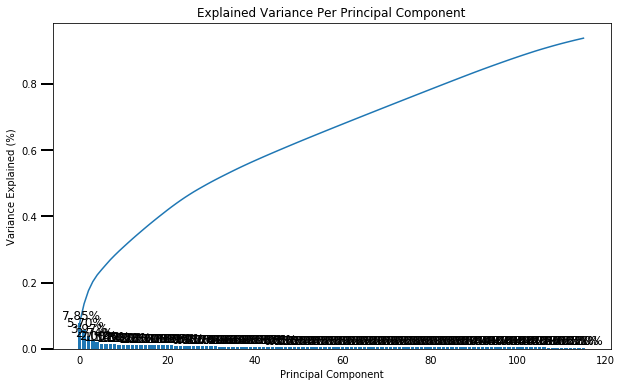

In [40]:
# Investigate the variance accounted for by each principal component.
# We build a scree plot using a helper function
# All credit for this function goes to Udacity,
# I got it from the helper_functions.py file made available with the course
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [41]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 70)
azdias_pca = pca.fit_transform(azdias_scaled)

Due to the number of components in the first attempt, it is hard to get at insights on one particular component. We can see that the first component captures 7.85% of the variance, the second one 5.70%. Nonetheless, plotting the cumulated explained variance is informative: we can see that with 70 components, we capture approximately 70% of the original variance. This satisfies our desire for fewer components while retaining enough information, and hence we choose to perform the analysis with 70 principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [42]:
# We write a function to extract the weights associated with each feature for a given component

def show_weights(pca, df, i):
    '''
    Extracts the weights associated with each feature for the i-th component
    
    INPUT: pca - our instance of PCA
           df - our original dataset (before PCA) 
           i - the component we are interested in 
    OUTPUT:
           a sorted Series of features and their associated weights 
    ''' 

    components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_filled.keys())
    return(components.loc[i,:].sort_values())

In [43]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# For the first principal component, we pass 0 as an argument since it is 0-indexed
# We only show the first 10 and last 10
first_weights = show_weights(pca, azdias_filled, 0)
print(first_weights.head(10))
print('\n')
print(first_weights.tail(10))

FINANZ_MINIMALIST    -0.1887
MOBI_REGIO           -0.1857
PLZ8_ANTG1           -0.1848
KBA05_GBZ            -0.1808
KBA05_ANTG1          -0.1786
KONSUMNAEHE          -0.1389
PLZ8_GBZ             -0.1343
INNENSTADT           -0.1309
RURAL                -0.1163
LP_STATUS_GROB_4.0   -0.1133
Name: 0, dtype: float64


LP_STATUS_FEIN_1.0    0.1258
KBA05_ANTG4           0.1295
FINANZ_HAUSBAUER      0.1459
EWDICHTE              0.1569
ORTSGR_KLS9           0.1601
PLZ8_ANTG4            0.1758
HH_EINKOMMEN_SCORE    0.1808
WEALTH                0.1814
PLZ8_ANTG3            0.1837
LP_STATUS_GROB_1.0    0.1945
Name: 0, dtype: float64


In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_weights = show_weights(pca, azdias_filled, 1)
print(second_weights.head(10))
print('\n')
print(second_weights.tail(10))

DECADE                  -0.2296
FINANZ_SPARER           -0.2267
SEMIO_REL               -0.2181
FINANZ_UNAUFFAELLIGER   -0.2142
SEMIO_TRADV             -0.2072
SEMIO_PFLICHT           -0.2047
FINANZ_ANLEGER          -0.2013
SEMIO_KULT              -0.1716
SEMIO_RAT               -0.1641
ONLINE_AFFINITAET       -0.1591
Name: 1, dtype: float64


FINANZTYP_5.0           0.0949
LP_STATUS_FEIN_1.0      0.0950
CJT_GESAMTTYP_2.0       0.1088
W_KEIT_KIND_HH          0.1183
RETOURTYP_BK_S          0.1528
SEMIO_LUST              0.1617
SEMIO_ERL               0.1853
ZABEOTYP_3.0            0.2004
FINANZ_VORSORGER        0.2177
ALTERSKATEGORIE_GROB    0.2320
Name: 1, dtype: float64


In [45]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_weights = show_weights(pca, azdias_filled, 2)
print(third_weights.head(10))
print('\n')
print(third_weights.tail(10))

ANREDE_KZ_2.0        -0.3336
SEMIO_KAEM           -0.3021
SEMIO_DOM            -0.2729
SEMIO_KRIT           -0.2507
SEMIO_ERL            -0.1895
SEMIO_RAT            -0.1587
FINANZ_ANLEGER       -0.1470
FINANZTYP_1.0        -0.0994
SHOPPER_TYP_2.0      -0.0827
LP_STATUS_FEIN_2.0   -0.0779
Name: 2, dtype: float64


SEMIO_REL            0.0965
ZABEOTYP_1.0         0.0986
SHOPPER_TYP_0.0      0.1117
FINANZTYP_5.0        0.1227
FINANZ_MINIMALIST    0.1251
SEMIO_KULT           0.2360
SEMIO_SOZ            0.2388
SEMIO_FAM            0.2429
SEMIO_VERT           0.3046
ANREDE_KZ_1.0        0.3336
Name: 2, dtype: float64


For the first principal component, we have positive weights on variables which describe areas with a lot of family homes (PLZ8_ANTG3, 4), low income (LP_STATUS_FEIN/GROB_1.0) as well as a lot of importance to the WEALTH variable. Conversely, there are negative weights associated with INNENSTADT, RURAL and KONSUMNAEHE which all relate to these people having an urban lifestyle. 
Putting this together, the first component seems to capture information related to low-income families living in urban centers.

For the second principal component, we have a negative weight associated with the decade variable, a low online affinity (ONLINE_AFFINITAET) as well as a lot of levels of the SEMIO variable which relate to having conservative, traditional values. Conversely, the positive weights are associated with levels of the FINANZTYP variable which describe savers/investors, which are prepared for unforeseen expensitures, and levels of the SEMIO variable which describe sensual-minded or event-oriented people.
Putting this all together, the second component seems to capture information related to older people who reject traditional, conservative values, financially stable and comfortable who want to seize the pleasures of life.

The third principal component displays similar negative weights as the first one, signifying urban people. They also seem to reject investing (FINANZ_ANLEGER), event (SEMIO_ERL) and are not very combative (SEMIO_KAEM). On the other hand, they are dreamful and socially-minded (SEMIO_VERT and SEMIO_SOZ), care about green energy (ZABEOTYP_1.0) and are mostly male (ANREDE_KZ_1.0).
Putting this all together, these people are mostly avant-garde avant-garde males who live some sort of bohemian lifestyle. I picture a typical Berliner supporter of the Green party when I think of them.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

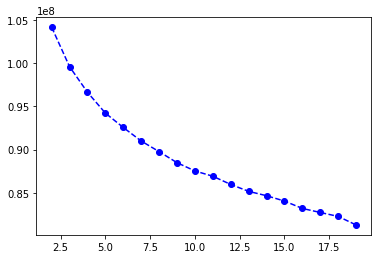

In [46]:
# Over a number of different cluster counts...
df = pd.DataFrame()
for k in range(2,20):

    # run k-means clustering on the data and...
    model = KMeans(n_clusters=k)
    model.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    df = pd.concat([df,pd.DataFrame([[k,np.abs(model.score(azdias_pca))]])])

plt.plot(df[0], df[1], linestyle='--', marker='o', color='b')

In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters = 13)
kmeans = model.fit(azdias_pca)
clusters_general_pop = kmeans.predict(azdias_pca)

Looking at the scree plot, there isn't a clear elbow we can choose to determine the number of clusters. After a first deceleration of decline at 7 cluster, another slowdown appears at 13. As a result, we choose this second option as our number of clusters for our solution.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

In [55]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# We start with applying the pre-processing function
customers_cleaned, customers_missing_rows = clean_data(customers)

# We need to impute the missing values to be able to apply our scaler
customers_filled = customers_cleaned.apply(lambda x:x.fillna(x.value_counts().index[0]))

# We scale our features in the same way as the general population data
customers_scaled = fitted_scaler.transform(customers_filled)

# We obtain the same components for the customers data as the general population data
customers_pca = pca.transform(customers_scaled)

# Finally, we obtain the distribution of the customers in the clusters built for the general population
clusters_customers = kmeans.predict(customers_pca)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [57]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# We start by comparing the proportion of rows excluded due to high missing values
prop_row_missing_azdias = excluded_rows_azdias/azdias_reduced.shape[0]
prop_row_missing_customers = customers_missing_rows/customers.shape[0]

prop_row_missing_azdias, prop_row_missing_customers

(0.088804011575131195, 1.5653371736271994e-05)

In [58]:
# We then create a dataframe, with each column representing a cluster
# and three rows: its proportion in the general population, in the customers, 
# and the absolute difference between the two
# when we calculate the proportion, we remember to add the rows we removed because of high missing values

# We start by calculating the total population
total_general_pop = azdias.shape[0]
total_customers = customers.shape[0]

# We create the dataframe with proportions for each cluster
cluster_prop = pd.DataFrame(data = [np.unique(clusters_general_pop, return_counts=True)[1],
                                    np.unique(clusters_customers, return_counts=True)[1]],
                            columns = np.unique(clusters_general_pop))

cluster_prop.iloc[0,:] = cluster_prop.iloc[0,:]/total_general_pop
cluster_prop.iloc[1,:] = cluster_prop.iloc[1,:]/total_customers

# We then calculate the difference to be able to see which clusters are over vs. under-represented
diff = cluster_prop.diff(axis = 0).iloc[1,:]
cluster_prop = cluster_prop.append(diff)
cluster_prop.index = [['general_pop', 'customers', 'absolute_diff']]

In [59]:
# We visualize our dataframe to make sure it captures the desired information
cluster_prop

,0,1,2,3,4,5,6,7,8,9,10,11,12
general_pop,0.087477,0.114452,0.090876,0.070778,0.030290,0.116854,0.099066,0.010275,0.032509,0.079584,0.041595,0.107685,0.029755
customers,0.243243,0.076477,0.219502,0.047665,0.006767,0.146776,0.059932,0.054729,0.068671,0.005766,0.030905,0.007300,0.032251
absolute_diff,0.155766,-0.037975,0.128626,-0.023114,-0.023522,0.029922,-0.039135,0.044455,0.036162,-0.073818,-0.010690,-0.100385,0.002496


In [60]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# We visualize the cluster which has the the max difference

max_index = cluster_prop.idxmax(axis = 1)[2]

# We get a dataframe with all the cluster centroids, based on the principal components
centers = pd.DataFrame(np.round(kmeans.cluster_centers_, 4))

# We filter for only the cluster which is overrepresented in the customer data
# We look at the greatest absolute values for the centroids
print(centers.iloc[max_index,:].head())
print('\n')
print(centers.iloc[max_index,:].tail())

0   -1.5149
1   -4.2938
2   -0.7984
3   -0.9783
4   -0.6476
Name: 0, dtype: float64


65    0.0217
66   -0.0160
67   -0.0190
68    0.0185
69   -0.0443
Name: 0, dtype: float64


In [61]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# We visualize the cluster which has the the max difference

min_index = cluster_prop.idxmin(axis = 1)[2]

# We get a dataframe with all the cluster centroids, based on the principal components
centers = pd.DataFrame(np.round(kmeans.cluster_centers_, 4))

# We filter for only the cluster which is overrepresented in the customer data
# We look at the greatest absolute values for the centroids
print(centers.iloc[min_index,:].head())
print('\n')
print(centers.iloc[min_index,:].tail())

0    4.7242
1   -1.9604
2   -2.6547
3    0.4165
4   -0.4098
Name: 11, dtype: float64


65   -0.0292
66    0.0474
67    0.0314
68    0.0049
69    0.0465
Name: 11, dtype: float64


The mail-order company over-indexes on people who are very different from the first and second components combined. Based on the description of these two elements above, we could say they do not do well with low-income families in cities as well as well-off older people with low digital fluency.

We can also see this company under-indexes on people who resemble the first component, but are opposite to the second one. This confirms our intuition that urban people are definitely not the target audience for this mail-order company.

In [2]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 522693 bytes to Identify_Customer_Segments.html']